In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
from pathlib import Path
from ema_pytorch import EMA
from datetime import datetime
from utils.sim_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from utils.couzin_utils import *
from utils.vec_sim_utils import *
from utils.encoder_utils import *
from utils.dataset_utils import *
from geomloss import SamplesLoss
from utils.mmd_loss import MMDLoss
from models.Generator import ModularPolicy
from models.Discriminator import Discriminator

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
# Expert Data Generation
max_steps = 500         # steps per episode

# Training Setup
num_generations = 3000  # training generations
gamma = 0.999           # decay factor
pretrain=False          # BC pretrain
performance_eval = 5    # evaluate performance every n generations
num_perturbations = 64  # perturbations for ES

# Policy
lr_policy = 5e-4        # learning rate policy
sigma = 0.1             # scatter for ES (exploration)

# Discriminator
dis_balance_factor = 2  # discriminator steps per policy step
noise = 0.005           # discriminator input noise
lr_disc = 5e-4          # learning rate discriminator
lambda_gp = 5           # gradient penalty factor
prey_update_mode = {"mode": "mean", "lambda": None} # prey update mode

# Env Settings (Expert Generation = Training)
height = 50
width = 50
prey_speed = 5
pred_speed = 5
step_size = 0.5
theta_dot_max = 0.5 # max turn rate
max_turn = float(theta_dot_max * step_size) + 1e-12 # max turn per step

pert_steps = 100 # perturbation steps
init_steps = 500 # initial steps

env_settings = (height, width, prey_speed, pred_speed, step_size, max_turn, pert_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib tk
# generate Expert Data with Couzin Model
_, exp_prey_sequence, couzin_metrics, actions, init_pool = run_couzin_simulation(visualization="off", 
                                                                                 max_steps=init_steps, 
                                                                                 constant_speed=prey_speed, shark_speed=pred_speed, 
                                                                                 area_width=width, area_height=height,
                                                                                 dt = step_size,
                                                                                 alpha=0.01,
                                                                                 theta_dot_max=theta_dot_max, theta_dot_max_shark=theta_dot_max,
                                                                                 number_of_sharks=0, n=32)
%matplotlib inline

# move to device (GPU training only)
exp_prey_sequence = exp_prey_sequence.to(device)
init_pool = init_pool.to(device)

# create windows for training
exp_prey_tensor = sliding_window(exp_prey_sequence, window_size=10)
print("Prey Tensor Shape:", exp_prey_sequence.shape)

Prey Tensor Shape: torch.Size([500, 32, 31, 5])


epoch 010: loss=23.704922 sim=0.0646 std=1.3645 cov=0.3243 std_mean=0.318
epoch 020: loss=22.733658 sim=0.0541 std=1.3134 cov=0.3358 std_mean=0.343
epoch 030: loss=21.948784 sim=0.0461 std=1.2442 cov=0.4265 std_mean=0.378
epoch 040: loss=21.446857 sim=0.0465 std=1.2157 cov=0.4099 std_mean=0.392
epoch 050: loss=21.054569 sim=0.0461 std=1.1788 cov=0.4438 std_mean=0.411
epoch 060: loss=20.908609 sim=0.0491 std=1.1435 cov=0.5054 std_mean=0.428
epoch 070: loss=20.719048 sim=0.0483 std=1.1157 cov=0.5552 std_mean=0.442
epoch 080: loss=20.687096 sim=0.0541 std=1.1012 cov=0.5634 std_mean=0.449
epoch 090: loss=20.706278 sim=0.0511 std=1.1112 cov=0.5520 std_mean=0.444
epoch 100: loss=20.814255 sim=0.0548 std=1.1082 cov=0.5640 std_mean=0.446
epoch 110: loss=20.444412 sim=0.0546 std=1.1011 cov=0.5123 std_mean=0.449
epoch 120: loss=20.536224 sim=0.0493 std=1.0968 cov=0.5705 std_mean=0.452
epoch 130: loss=20.383984 sim=0.0548 std=1.0824 cov=0.5556 std_mean=0.459
epoch 140: loss=20.347494 sim=0.0496 s

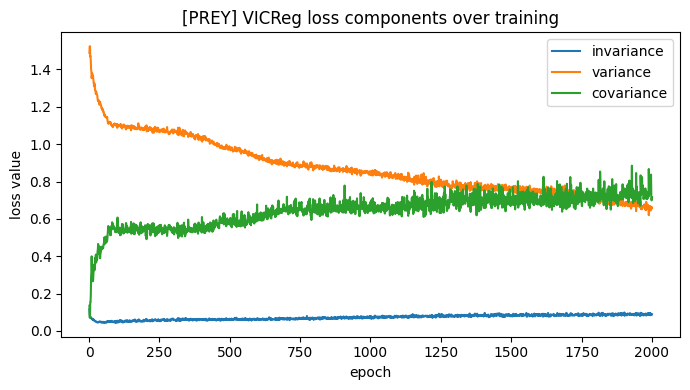

Prey Encoder trained & frozen.



In [4]:
# initialize trajectory augmentation
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)

# prey encoder training
prey_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=2000, optimizer=prey_optimizer, role="prey")

# freeze prey encoder
for p in prey_encoder.parameters():
    p.requires_grad = False 
prey_encoder.eval()
print("Prey Encoder trained & frozen.\n")

In [5]:
# initialize Prey Policy 
prey_policy = ModularPolicy(features=4).to(device)
prey_policy.set_parameters()

# pretrain prey policy with behavior cloning
if pretrain:
    pretrain_policy(prey_policy, role="prey", expert_data=exp_prey_tensor, batch_size=4048, epochs=500, lr=1e-3, deterministic=True, device=device)

# initialize EMA for prey policy
ema_prey = EMA(prey_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Prey Policy initialized.\n")

Prey Policy initialized.



In [6]:
# initialize prey discriminator
prey_discriminator = Discriminator(encoder=prey_encoder, role="prey", z_dim=32).to(device)
prey_discriminator.set_parameters(init=True)
optim_disc_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

# initialize losses
sinkhorn_loss = SamplesLoss(loss="sinkhorn", backend="tensorized")
prey_mmd_loss = MMDLoss(encoder=prey_encoder, role="prey").to(device)

In [ ]:
metrics_list = []
policy_metrics_list = []
disc_metrics_list = []

# Training Loop
for gen in range(num_generations):
    rollout_prey_policy = ema_prey.ema_model.to(device) # use EMA model for rollouts
    
    # generate rollouts with current EMA policy
    gen_pred_tensor, gen_prey_tensor = run_env_vectorized(prey_policy=rollout_prey_policy, 
                                                          pred_policy=None, 
                                                          n_prey=32, n_pred=0, 
                                                          step_size=step_size, max_steps=init_steps,
                                                          prey_speed=prey_speed, pred_speed=pred_speed, 
                                                          area_width=width, area_height=height, 
                                                          max_turn=max_turn,
                                                          init_pool=init_pool)

    for i in range(dis_balance_factor):
        # sample batches for discriminator update
        expert_prey_batch = sample_data(exp_prey_tensor, batch_size=10, window_len=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, batch_size=10, window_len=10).to(device)

        # prey discriminator update
        dis_metric_prey = prey_discriminator.update(expert_prey_batch, generative_prey_batch, optim_disc_prey, 
                                                    lambda_gp, noise=noise, generation=gen, num_generations=num_generations)
        
        disc_metrics_list.append((dis_metric_prey, None))
        
    # sample initial positions for ES, same positions for all perturbations
    init_pos = init_positions(init_pool, batch=num_perturbations, mode="dual")

    # optimize PIN with ES
    pin_prey_metrics = optimize_es(pred_policy=None, prey_policy=prey_policy,
                                   role="prey", module="pairwise", mode=prey_update_mode, 
                                   discriminator=prey_discriminator, lr=lr_policy, sigma=sigma, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, 
                                   settings_batch_env=env_settings)
    
    # optimize AN with ES
    an_prey_metrics  = optimize_es(pred_policy=None, prey_policy=prey_policy,
                                   role="prey", module="attention", mode=prey_update_mode, 
                                   discriminator=prey_discriminator, lr=lr_policy, sigma=sigma,
                                   num_perturbations=num_perturbations, init_pos=init_pos,
                                   settings_batch_env=env_settings)
    ema_prey.update() # update EMA

    # append metrics
    policy_metrics_list.append({ "prey": (pin_prey_metrics, an_prey_metrics), "pred": (None, None)})
    
    # decay learning rate and sigma
    lr_policy *= gamma
    sigma *= gamma

    # evalute current policies
    current_prey_state = ema_prey.ema_model.state_dict()
    
    if gen % performance_eval == 0:
        # caluclate Sinkhorn and MMD metrics
        metrics = calculate_metrics(prey_policy=prey_policy, init_pool=init_pool, env_settings=env_settings,
                                    prey_encoder=prey_encoder, exp_prey_tensor=exp_prey_tensor,
                                    prey_mmd_loss=prey_mmd_loss, sinkhorn_loss=sinkhorn_loss, device="cuda")
        metrics_list.append(metrics)

        # save best prey policy based on Sinkhorn
        best_prey = metrics["sinkhorn_prey_mean"]
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}
        
    if metrics["sinkhorn_prey_mean"] < best_prey:
        best_prey = metrics["sinkhorn_prey_mean"]
        print(f"New best Prey Sinkhorn: {best_prey.item()}\n")
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}
    
    print("Generation", gen+1)
    print(f"[PREY] PIN Network:   {pin_prey_metrics}")
    print(f"[PREY] AN Network:    {an_prey_metrics}")
    print(f"[PREY] Discriminator: {dis_metric_prey}")
    print(f"[PREY] Score Diff: {abs(dis_metric_prey['expert_score_mean'] - dis_metric_prey['policy_score_mean'])}")
    print(f"[PREY] MMD: {metrics['mmd_prey_mean']:.4f} ± {metrics['mmd_prey_std']:.4f} | Sinkhorn: {metrics['sinkhorn_prey_mean']:.8f} ± {metrics['sinkhorn_prey_std']:.8f}\n")

# load best prey policy
prey_policy.load_state_dict(best_prey_policy_state, strict=True)

Generation 1
[PREY] PIN Network:   {'diff_mean': -4e-06, 'diff_std': 4.9e-05, 'delta_norm': 0.093909, 'clip_ratio': 0.286888, 'delta_raw_norm': 0.327337, 'max_delta_norm': 0.093909, 'avoid/attack reward': None}
[PREY] AN Network:    {'diff_mean': 1e-06, 'diff_std': 2.1e-05, 'delta_norm': 0.093811, 'clip_ratio': 0.291287, 'delta_raw_norm': 0.322058, 'max_delta_norm': 0.093811, 'avoid/attack reward': None}
[PREY] Discriminator: {'dis_loss': 0.0003, 'dis_loss_gp': 4.9149, 'grad_penalty': 0.9829, 'expert_score_mean': -0.1466, 'policy_score_mean': -0.1462}
[PREY] Score Diff: 0.00040000000000001146
[PREY] MMD: 0.8613 ± 0.0566 | Sinkhorn: 0.00025540 ± 0.00001353



In [ ]:
# save trained prey policy
base_dir = Path(r"..\data\2. Training\training\PreyOnly - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

save_path = run_dir / "prey_only_policy.pth"
torch.save(prey_policy.state_dict(), save_path)

In [ ]:
# calculate expert baseline for comparison with trained policies
mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds = get_expert_values(exp_prey_tensor=exp_prey_tensor, 
                                                                        prey_mmd_loss=prey_mmd_loss, 
                                                                        prey_encoder=prey_encoder,
                                                                        sinkhorn_loss=sinkhorn_loss)

100%|██████████| 500/500 [00:17<00:00, 28.55it/s]


Expert Prey MMD: 0.010104448795318603 ± 0.005328258528423521
Expert Prey Sinkhorn: 4.333554472395917e-06 ± 7.15547888948242e-07


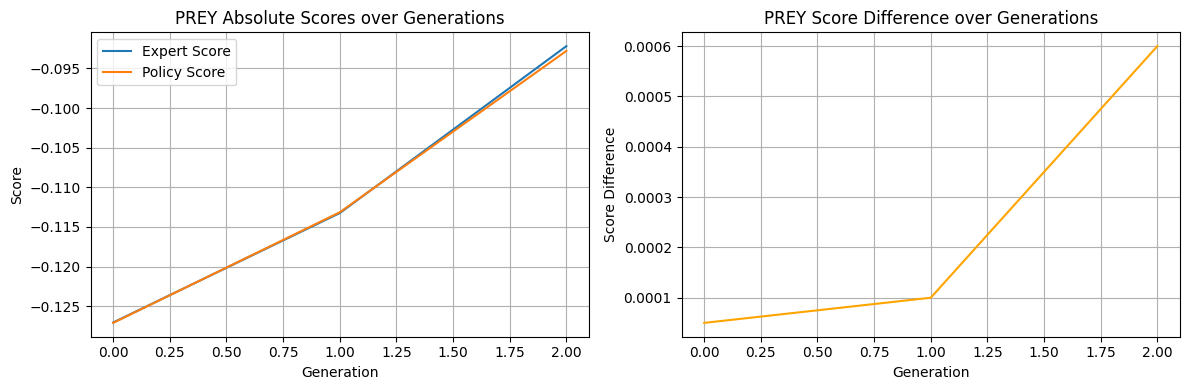

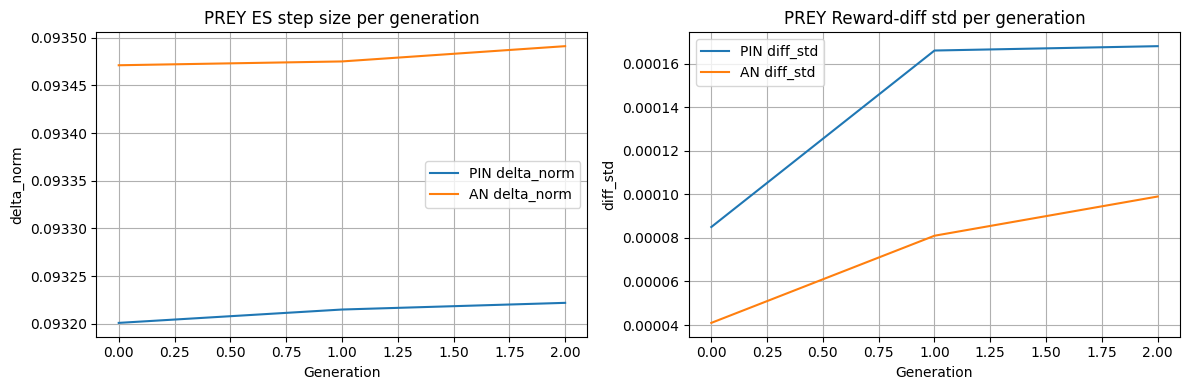

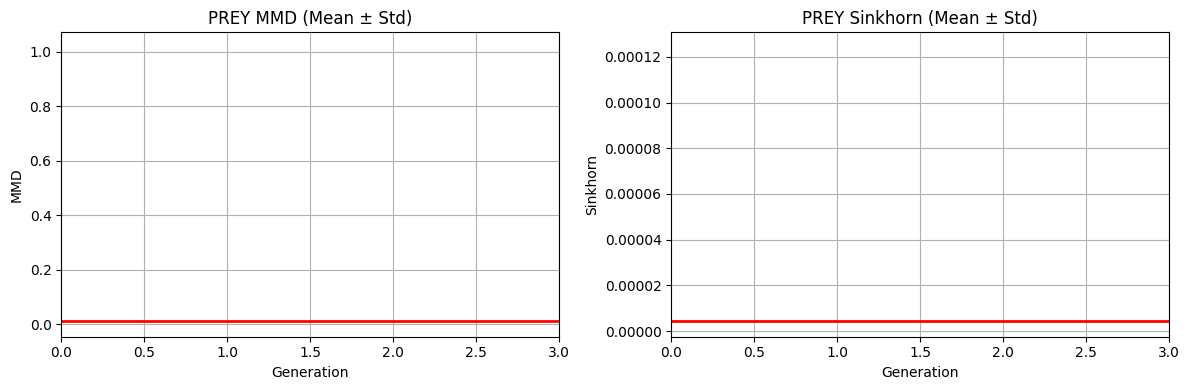

In [ ]:
%matplotlib inline
# plot training and evaluation metrics
plot_train_metrics(disc_metrics_list, dis_balance_factor, role="prey", save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="prey", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="prey", 
                  mmd_means=mmd_means, mmd_stds=mmd_stds, 
                  sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, 
                  max_steps=num_generations, save_dir=run_dir)

In [ ]:
%matplotlib tk
# visualize trained prey policy
_, gen_prey_tensor, _ = run_env_simulation(visualization='on', 
                                           prey_policy=prey_policy, pred_policy=None,
                                           n_prey=32, n_pred=0, 
                                           max_steps=100,
                                           pred_speed=pred_speed, prey_speed=prey_speed,
                                           area_width=width, area_height=height,
                                           max_turn = max_turn,
                                           step_size=step_size)

In [ ]:
%matplotlib tk
# visualize expert data again
_, exp_prey_sequence, couzin_metrics, actions, init_pool = run_couzin_simulation(visualization="on", 
                                                                                 max_steps=100, 
                                                                                 constant_speed=prey_speed, shark_speed=pred_speed, 
                                                                                 area_width=width, area_height=height,
                                                                                 dt = step_size,
                                                                                 alpha=0.01,
                                                                                 theta_dot_max=theta_dot_max, theta_dot_max_shark=theta_dot_max,
                                                                                 number_of_sharks=0, n=32)